In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import statsmodels.stats.api as sms
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

sns.set_style('whitegrid')

In [2]:
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    It uses Locally Weighted Scatterplot Smoothing (LOWESS) to fit a model. 
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    import matplotlib.pyplot as plt
    import seaborn as sns

    pred = model.fittedvalues
    influence = model.get_influence()
    resid_std = influence.resid_studentized_internal
    
    fig, ax = plt.subplots(1,2, figsize=(7.5,3.5))
    
    sns.regplot(x=pred, y=y, lowess=True, ax=ax[0], line_kws={'color':'darkorchid'})
    # I've added the ideal line (y=yhat) for comparison
    sns.lineplot(x=[min(pred), max(pred)], y=[min(pred), max(pred)], 
                 ax=ax[0], color='red', ls=':')
    ax[0].set_title('Observed vs. Fitted Values')
    ax[0].set_xlabel('Fitted')
    ax[0].set_ylabel('Observed')
    
    sns.regplot(x=pred, y=resid_std, lowess=True, ax=ax[1], line_kws={'color':'darkorchid'})
    # I've added the ideal line (y=0) for comparison
    sns.lineplot(x=[min(pred), max(pred)], y=[0,0], ax=ax[1], color='red', ls=':')
    ax[1].set_title('Residuals vs. Fitted Values')
    ax[1].set_xlabel('Fitted')
    ax[1].set_ylabel('Standardized Residual')
    
    return fig, ax

In [3]:
def homoscedasticity_test(model):
    '''
    Function for testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan 
    and Goldfeld-Quandt tests.
    
    Args:
    * model - fitted OLS model from statsmodels
    '''
    import statsmodels.stats.api as sms
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    
    pred = model.fittedvalues
    resid = model.resid
    resid_z = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2, figsize=(7.5,3.5))

    sns.regplot(x=pred, y=resid, lowess=True, ax=ax[0], line_kws={'color': 'darkorchid'})
    # I've added the ideal line (y=0) for comparison
    sns.lineplot(x=[min(pred), max(pred)], y=[0,0], ax=ax[0], color='red', ls=':')
    ax[0].set_title('Residuals vs. Fitted Values')
    ax[0].set(xlabel='Fitted', ylabel='Residual')

    sns.regplot(x=pred, y=np.sqrt(np.abs(resid_z)), lowess=True, ax=ax[1], line_kws={'color': 'darkorchid'})
    # I've added the ideal line for comparison
    sns.lineplot(x=[min(pred), max(pred)], y=[0.822,0.822], ax=ax[1], color='red', ls=':')
    ax[1].set_title('Scale-Location')
    ax[1].set(xlabel='Fitted', ylabel=r'$\sqrt{|{\mathrm{Standardized~Residual}}|}$')

    # Breusch-Pagan tests if regression on 'Residuals ~ Fitted Values' has non-zero slope
    # Good for picking up trends of strictly increasing or decreasing variance
    bp_test = pd.DataFrame(sms.het_breuschpagan(resid, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    # Goldfeld-Quandt tests if variance on left half of residual plot is equal to variance on right half
    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resid, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')
    
    return fig, ax

In [4]:
def normality_of_residuals_test(model):
    '''
    Function for drawing the normal QQ-plot of the residuals and running 5 statistical tests to 
    investigate the normality of residuals.
    
    Arg:
    * model - fitted OLS models from statsmodels
    '''
    import scipy.stats as stats
    import statsmodels.graphics.api as smg
    import statsmodels.stats.api as sms
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(4,3.5))
    smg.qqplot(data=model.resid, line='45', fit=True, ax=ax);
    ax.set_title('Q-Q plot');
    resid_z = model.get_influence().resid_studentized_internal

    sw = stats.shapiro(model.resid)
    dp = stats.normaltest(model.resid)
    jb = stats.jarque_bera(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    lf = sms.lilliefors(model.resid)
    ks = stats.kstest(resid_z, 'norm')
    
    print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f"D'Agostino-Pearson Omnibus test ---- statistic: {dp[0]:.4f}, p-value: {dp[1]:.4f}")
    print(f'Lilliefors test ---- statistic: {lf[0]:.4f}, p-value: {lf[1]:.4f}')
    print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
    print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, '\
          'the null hypothesis that the data come from the Normal distribution should be rejected. ')
    
    return fig, ax

In [5]:
def autocorrelation_plot(model):
    import statsmodels.tsa.api as smt
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(12,6))
    acf = smt.graphics.plot_acf(model.resid, lags=40, alpha=0.05, ax=ax)
    
    return fig, ax

# Data Preparation

In [6]:
from sklearn.model_selection import train_test_split

In [121]:
diabetes = pd.read_csv('diabetes_students.csv', index_col=0)
X = diabetes.drop(['Y'],axis=1)
y = diabetes['Y'][:-50]

In [122]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442 entries, 2 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGE     442 non-null    int64  
 1   SEX     442 non-null    object 
 2   BMI     442 non-null    float64
 3   BP      442 non-null    float64
 4   S1      442 non-null    int64  
 5   S2      442 non-null    float64
 6   S3      442 non-null    float64
 7   S4      442 non-null    float64
 8   S5      442 non-null    float64
 9   S6      442 non-null    int64  
 10  Y       392 non-null    float64
dtypes: float64(7), int64(3), object(1)
memory usage: 41.4+ KB


In [123]:
diabetes_test = X.iloc[-50:]
X = X.iloc[:-50]

In [10]:
X.describe()

,AGE,BMI,BP,S1,S2,S3,S4,S5,S6
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,48.612245,26.469388,94.781403,189.295918,115.641582,49.531888,4.089413,4.650294,91.678571
std,13.238039,4.417314,13.843620,33.978769,30.210071,12.933269,1.311757,0.523727,11.516640
min,19.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.496500,60.000000
25%,39.000000,23.300000,84.000000,165.000000,96.200000,40.000000,3.000000,4.276700,84.000000
50%,50.000000,25.700000,93.000000,187.000000,113.200000,48.000000,4.000000,4.634700,91.000000
75%,59.000000,29.525000,104.752500,211.000000,135.650000,57.000000,5.000000,5.010600,98.250000
max,79.000000,42.200000,133.000000,300.000000,242.400000,99.000000,9.090000,6.107000,124.000000


In [11]:
diabetes_test.describe()

,AGE,BMI,BP,S1,S2,S3,S4,S5,S6
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,47.780000,25.642000,93.593400,187.920000,113.852000,51.800000,3.920000,4.571770,87.980000
std,12.149225,4.399494,13.827758,39.558193,32.235683,12.893599,1.109434,0.511588,10.897463
min,21.000000,18.900000,65.000000,124.000000,48.800000,32.000000,2.000000,3.258100,58.000000
25%,38.000000,22.625000,85.167500,160.500000,92.150000,42.500000,3.000000,4.276700,79.500000
50%,47.500000,25.050000,90.500000,182.500000,106.900000,50.000000,4.000000,4.454300,91.000000
75%,58.500000,28.075000,105.000000,206.000000,126.350000,58.750000,4.412500,4.853925,95.750000
max,71.000000,41.300000,123.000000,301.000000,215.000000,97.000000,7.000000,6.107000,109.000000


In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
diab_train = X_train.join(y_train)
diab_val = X_val.join(y_val)

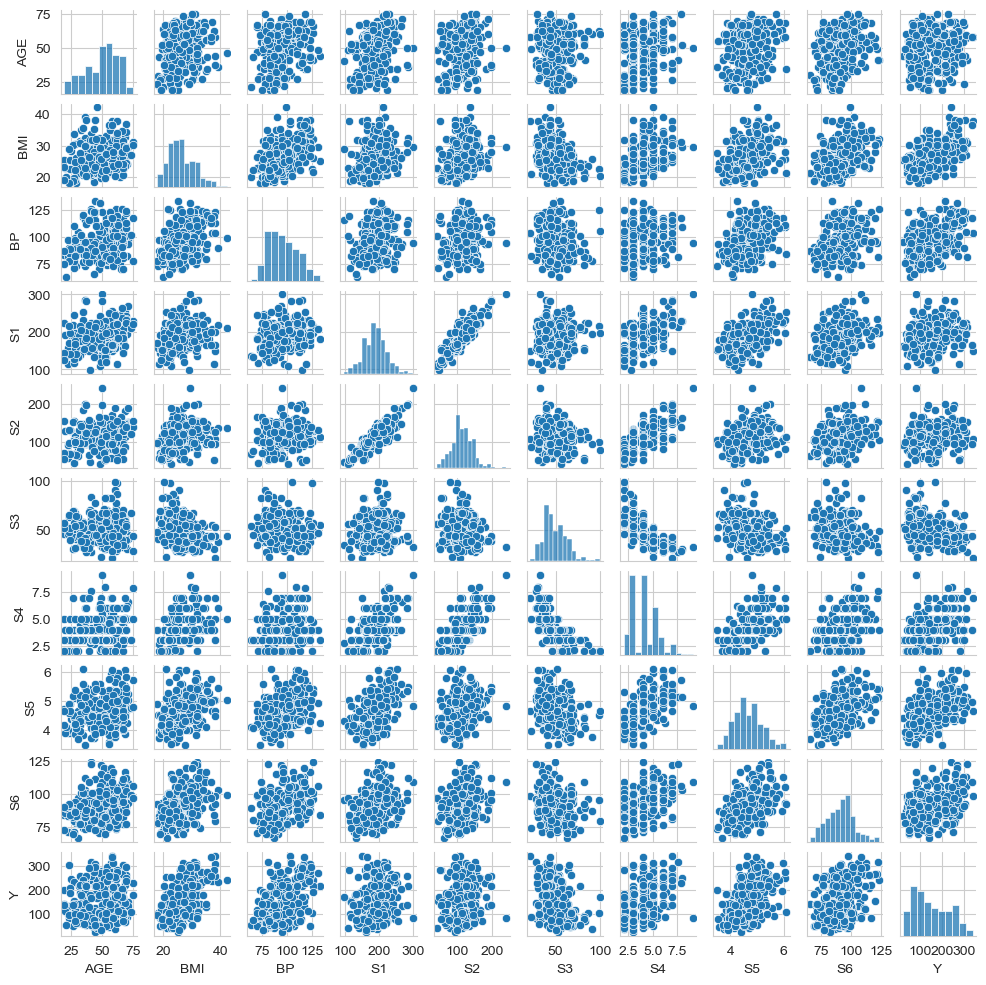

In [13]:
sns.pairplot(diab_train, height=1)

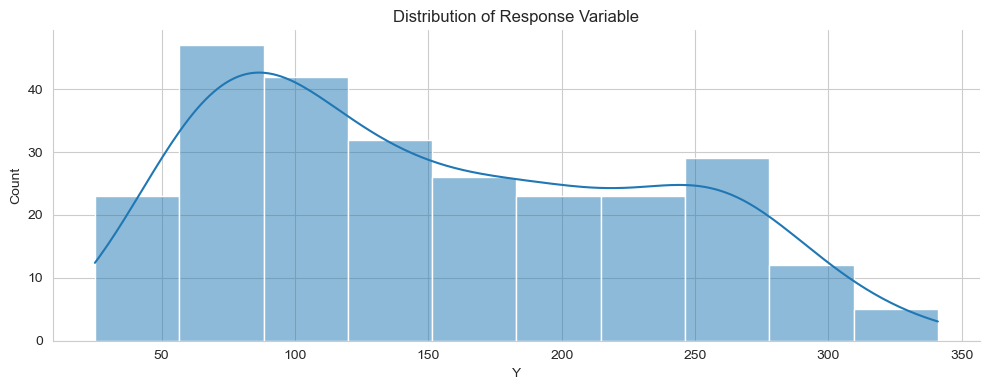

In [20]:
fg = sns.displot(data=y_train, kde=True, aspect=2.5, height=4)
fig, ax = fg.fig, fg.ax
ax.set_title('Distribution of Response Variable')
fig.tight_layout()
plt.savefig('Ydist.svg')
plt.show()

In [15]:
y_bc, lamb, ci = stats.boxcox(y_train, alpha=0.1)

In [16]:
ci

(0.14092994141268164, 0.526274306176228)

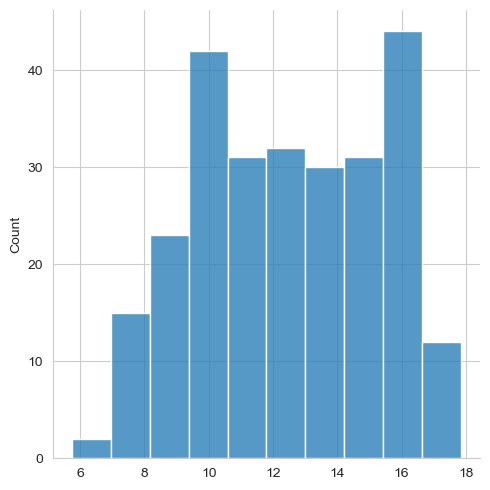

In [19]:
sns.displot(y_bc)
plt.show()

This now looks left-skewed, so I'm going to use a square root transformation instead. That seems to result in a symmetric distribution.

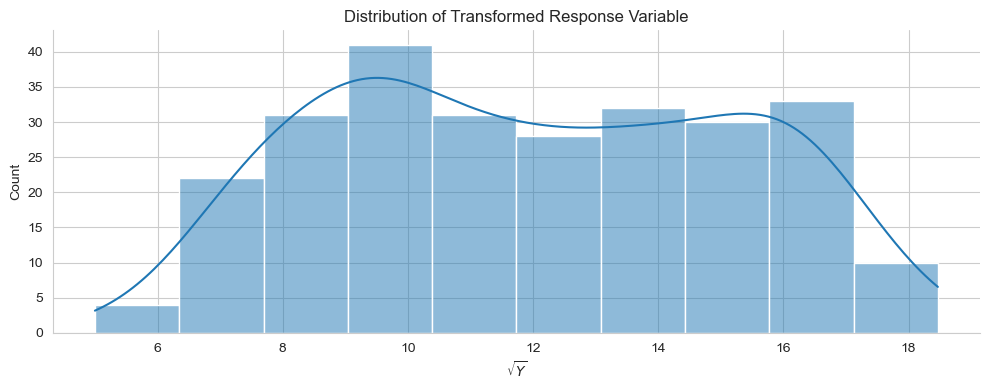

In [21]:
fg = sns.displot(data=y_train.apply(np.sqrt), kde=True, aspect=2.5, height=4)
fig, ax = fg.fig, fg.ax
ax.set_title('Distribution of Transformed Response Variable')
ax.set_xlabel(r'$\sqrt{Y}$')
fig.tight_layout()
plt.savefig('YtransformDist.svg')
plt.show()

I want the column names to match what is needed by Patsy formulas, so I did it manually. I used some extra bits to make sure that first-order terms are including with squared terms and interaction terms (that's why there are * instead of : in the interactions)

In [22]:
X_poly = X_train.drop('SEX', axis=1).apply(stats.zscore)
X_poly['C(SEX)'] = X_train['SEX'].map({'Male':0,'Female':1})

In [23]:
for ii in range(len(X_poly.columns)):
    col1 = X_poly.columns[ii]
    if col1 != 'C(SEX)':
        X_poly[col1 + ' + I(' + col1 + '**2)'] = X_poly[col1] ** 2
    for jj in range(ii+1,len(X_train.columns)):
        col2 = X_poly.columns[jj]
        X_poly[col1 + '*' + col2] = X_poly[col1] * X_poly[col2]
X_poly.head()   

,AGE,BMI,BP,S1,S2,S3,S4,S5,S6,C(SEX),...,S3*C(SEX),S4 + I(S4**2),S4*S5,S4*S6,S4*C(SEX),S5 + I(S5**2),S5*S6,S5*C(SEX),S6 + I(S6**2),S6*C(SEX)
411,0.023293,1.156355,-0.947193,-1.572923,-1.525541,0.411414,-1.595194,-1.133124,-0.568759,1,...,0.411414,2.544645,1.807554,0.907281,-1.595194,1.283971,0.644475,-1.133124,0.323487,-0.568759
209,0.701370,-0.395854,1.295907,-1.100460,-0.349715,-1.582574,0.692762,-0.288800,-0.306409,0,...,-0.000000,0.479919,-0.200070,-0.212268,0.000000,0.083405,0.088491,-0.000000,0.093886,-0.000000
136,-2.010939,-1.685718,-1.227581,-1.307162,-1.433060,1.024948,-1.595194,-1.455542,-0.481309,1,...,1.024948,2.544645,2.321872,0.767782,-1.595194,2.118602,0.700566,-1.455542,0.231659,-0.481309
350,-0.654785,1.200079,2.137069,0.257871,-0.369532,-0.048737,-0.069890,1.465891,2.841793,0,...,-0.000000,0.004885,-0.102452,-0.198614,-0.000000,2.148836,4.165759,0.000000,8.075790,0.000000
254,0.550686,1.112631,1.506197,1.055152,-0.257234,-0.738964,1.455414,2.531134,1.879843,0,...,-0.000000,2.118229,3.683847,2.735949,0.000000,6.406641,4.758134,0.000000,3.533809,0.000000


# Model Selection - Method 1 (Lasso AIC)

I used Lasso for model selection, focusing on minimizing AIC.

In [24]:
from sklearn.linear_model import Lasso

I wanted to loop through a bunch of values of alpha and get the coefficients.

In [25]:
coefs = pd.DataFrame(columns=X_poly.columns)
for alpha in np.arange(0.01,2,0.01):
    lm = Lasso(alpha=alpha, max_iter=10000)
    lm.fit(X_poly, np.sqrt(y_train))
    coefs.loc[alpha] = (lm.coef_)

In [26]:
coefs.head()

,AGE,BMI,BP,S1,S2,S3,S4,S5,S6,C(SEX),...,S3*C(SEX),S4 + I(S4**2),S4*S5,S4*S6,S4*C(SEX),S5 + I(S5**2),S5*S6,S5*C(SEX),S6 + I(S6**2),S6*C(SEX)
0.01,0.368843,1.381720,0.835979,-0.317254,-0.0,-0.340690,0.0,1.057864,0.053709,0.992106,...,-0.299518,0.164379,0.001814,-0.129632,0.121812,0.143494,0.392870,-0.0,0.285699,-0.179278
0.02,0.294869,1.265835,0.802926,-0.192893,-0.0,-0.418336,0.0,0.971607,0.000000,0.894835,...,-0.239870,0.093833,-0.000000,-0.000000,0.057778,-0.003059,0.306213,-0.0,0.268116,-0.082763
0.03,0.226397,1.172237,0.754826,-0.092278,-0.0,-0.460456,0.0,0.915117,0.000000,0.817322,...,-0.193011,0.058272,-0.000000,-0.000000,0.025091,-0.056369,0.244838,-0.0,0.270363,-0.045920
0.04,0.158585,1.118770,0.709480,-0.062805,-0.0,-0.469993,0.0,0.898095,0.000000,0.736308,...,-0.137834,0.000000,-0.000000,0.000000,0.000000,-0.059831,0.184853,-0.0,0.266829,-0.016056
0.05,0.085962,1.059744,0.689358,-0.040464,-0.0,-0.475595,0.0,0.884995,0.000000,0.656283,...,-0.060316,0.000000,-0.000000,0.000000,0.000000,-0.042292,0.127143,-0.0,0.261750,-0.000000


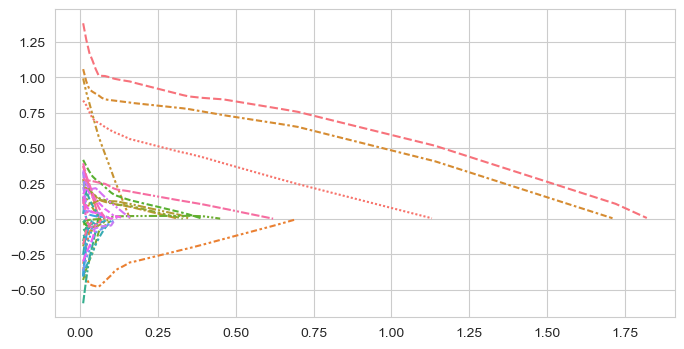

In [27]:
fig, ax = plt.subplots(figsize=(8,4))
sns.lineplot(data=coefs[coefs != 0], ax=ax, legend=False)
plt.show()

The below functions help me by defining the model formula suggested by feature inclusion in the Lasso model with a given alpha.

In [28]:
def form(alpha):
    row = int(100 * alpha - 1)
    non_zero_coefs = coefs.iloc[row][coefs.iloc[row] != 0]
    formula = 'I(Y ** 0.5) ~ '
    for term in non_zero_coefs.index:
        formula += term + ' + '
    return formula[:-3]

In [29]:
def mdl(formula):
    return smf.ols(formula, data=diab_train).fit()

I then looped through all the models suggested by Lasso and found the ones with the lowest AIC.

In [165]:
aicmin = 1000000
alpha_best = 0
for alpha in np.arange(0.01,1.75,0.01):
    aic = mdl(form(alpha)).aic
    if aic <= aicmin:
        aicmin = aic
        alpha_best = alpha

In [166]:
alpha_best

0.16

In [167]:
formula = form(alpha_best)
formula

'I(Y ** 0.5) ~ BMI + BP + S3 + S5 + C(SEX) + AGE + I(AGE**2) + AGE*BP + AGE*S5 + BMI + I(BMI**2) + BMI*BP + S3*S5 + S6 + I(S6**2)'

By using * instead of :, I've ensured that all main effects are included when an interaction is included, so I know this model is built ok. Let's look at it.

In [168]:
model = mdl(formula)
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.514    
Dependent Variable: I(Y ** 0.5)      AIC:                1184.3436
Date:               2023-03-02 10:36 BIC:                1237.8688
No. Observations:   262              Log-Likelihood:     -577.17  
Df Model:           14               F-statistic:        20.70    
Df Residuals:       247              Prob (F-statistic): 3.52e-34 
R-squared:          0.540            Scale:              5.0884   
------------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------
Intercept          39.9510  11.4855  3.4784 0.0006 17.3289 62.5731
C(SEX)[T.Male]     -0.8931   0.3161 -2.8258 0.0051 -1.5156 -0.2706
BMI                -0.1761   0.3197 -0.5508 0.5823 -0.8057  0.4536
BP                 -0.0898   0.0831 -1.0807 0.2809 -0.2535  0.0739
S3                 -0.2000   0.1074 -1.8628 0.0637 -0.4115  0.0115
S5                 -0.8739   1.7041 -0.5128 0.6085 -4.2304  2.4825
AGE                -0.2561   0.1106 -2.3154 0.0214 -0.4739 -0.0382
I(AGE ** 2)         0.0010   0.0008  1.1779 0.2400 -0.0007  0.0026
AGE:BP              0.0009   0.0009  0.9266 0.3550 -0.0010  0.0027
AGE:S5              0.0175   0.0237  0.7387 0.4608 -0.0292  0.0643
I(BMI ** 2)         0.0009   0.0060  0.1564 0.8759 -0.0108  0.0127
BMI:BP              0.0037   0.0025  1.4693 0.1430 -0.0012  0.0086
S3:S5               0.0342   0.0234  1.4599 0.1456 -0.0119  0.0803
S6                 -0.3604   0.1529 -2.3574 0.0192 -0.6614 -0.0593
I(S6 ** 2)          0.0020   0.0008  2.4167 0.0164  0.0004  0.0036
------------------------------------------------------------------
Omnibus:               1.904        Durbin-Watson:          2.047 
Prob(Omnibus):         0.386        Jarque-Bera (JB):       1.630 
Skew:                  -0.051       Prob(JB):               0.443 
Kurtosis:              2.627        Condition No.:          889239
==================================================================
* The condition number is large (9e+05). This might indicate
strong multicollinearity or other numerical problems.
"""

Iteratively performing backward elimination, ensuring we don't remove main effects before removing interactions and squared terms including them, we end up with...

In [169]:
model1 = mdl(formula + ' - I(BMI**2) - AGE:S5 - AGE:BP')
print(model1.aic)
model1.tvalues.apply(np.abs).sort_values()

1180.60873412378


S5                0.079462
BMI               0.778067
BP                0.900088
S3:S5             1.406161
S3                1.825335
BMI:BP            1.832620
AGE               2.009239
I(AGE ** 2)       2.017420
S6                2.467067
I(S6 ** 2)        2.516407
C(SEX)[T.Male]    3.088028
Intercept         3.229580
dtype: float64

In [170]:
model1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.515    
Dependent Variable: I(Y ** 0.5)      AIC:                1180.6087
Date:               2023-03-02 10:36 BIC:                1223.4289
No. Observations:   262              Log-Likelihood:     -578.30  
Df Model:           11               F-statistic:        26.24    
Df Residuals:       250              Prob (F-statistic): 7.71e-36 
R-squared:          0.536            Scale:              5.0710   
------------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------
Intercept          33.7592  10.4531  3.2296 0.0014 13.1718 54.3466
C(SEX)[T.Male]     -0.9613   0.3113 -3.0880 0.0022 -1.5744 -0.3482
BMI                -0.1718   0.2208 -0.7781 0.4373 -0.6066  0.2631
BP                 -0.0555   0.0616 -0.9001 0.3689 -0.1769  0.0659
S3                 -0.1955   0.1071 -1.8253 0.0691 -0.4065  0.0154
S5                  0.0939   1.1817  0.0795 0.9367 -2.2335  2.4213
AGE                -0.1427   0.0710 -2.0092 0.0456 -0.2825 -0.0028
I(AGE ** 2)         0.0015   0.0007  2.0174 0.0447  0.0000  0.0030
BMI:BP              0.0041   0.0022  1.8326 0.0680 -0.0003  0.0085
S3:S5               0.0329   0.0234  1.4062 0.1609 -0.0132  0.0789
S6                 -0.3753   0.1521 -2.4671 0.0143 -0.6749 -0.0757
I(S6 ** 2)          0.0020   0.0008  2.5164 0.0125  0.0004  0.0036
------------------------------------------------------------------
Omnibus:               1.862        Durbin-Watson:          2.032 
Prob(Omnibus):         0.394        Jarque-Bera (JB):       1.594 
Skew:                  -0.043       Prob(JB):               0.451 
Kurtosis:              2.628        Condition No.:          717295
==================================================================
* The condition number is large (7e+05). This might indicate
strong multicollinearity or other numerical problems.
"""

**Model Selected**: $\sqrt{\hat{Y}} = 33.76 - 0.9613(\text{SEX}==\text{MALE}) - 0.1718(\text{BMI}) - 0.0555(\text{BP}) - 0.1955(\text{S3}) + 0.0939(\text{S5}) - 0.1427(\text{AGE}) + 0.0015(\text{AGE}^2) + 0.0041 (\text{BMI}\times\text{BP}) + 0.0329(\text{S3}\times\text{S5}) - 0.3753(\text{S6}) + 0.0020(\text{S6}^2)$

In [62]:
rmse_val1 = mean_squared_error(y_val, model1.predict(X_val)**2) ** 0.5
print(rmse_val1)

55.215028547317466


# Model Selection: Method 2 (Lasso BIC)
Using the same Lasso method as before, I instead looped through the suggested models to find the lowest BIC. This is a **much** smaller model.

In [63]:
bicmin = 1000000
alpha_best = 0
for alpha in np.arange(0.01,1.75,0.01):
    bic = mdl(form(alpha)).bic
    if bic <= bicmin:
        bicmin = bic
        alpha_best = alpha

In [64]:
alpha_best

0.6900000000000001

In [65]:
model2 = mdl(form(alpha_best))
model2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.473    
Dependent Variable: I(Y ** 0.5)      AIC:                1195.7396
Date:               2023-03-02 06:55 BIC:                1213.5814
No. Observations:   262              Log-Likelihood:     -592.87  
Df Model:           4                F-statistic:        59.61    
Df Residuals:       257              Prob (F-statistic): 1.48e-35 
R-squared:          0.481            Scale:              5.5130   
-------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-------------------------------------------------------------------
Intercept      -4.9445    1.8851  -2.6230  0.0092  -8.6567  -1.2324
BMI             0.2225    0.0377   5.9106  0.0000   0.1484   0.2967
BP              0.0469    0.0116   4.0465  0.0001   0.0241   0.0697
S3             -0.0337    0.0124  -2.7068  0.0072  -0.0582  -0.0092
S5              1.7607    0.3369   5.2269  0.0000   1.0974   2.4241
------------------------------------------------------------------
Omnibus:              4.624         Durbin-Watson:           2.019
Prob(Omnibus):        0.099         Jarque-Bera (JB):        2.974
Skew:                 -0.041        Prob(JB):                0.226
Kurtosis:             2.484         Condition No.:           1462 
==================================================================
* The condition number is large (1e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

In [183]:
model2.summary2(alpha=0.01).tables[1].to_clipboard()

**Model Selected**: $\sqrt{\hat{Y}} = -4.9445 + 0.2225(\text{BMI}) + 0.0469(\text{BP}) - 0.0337(\text{S3}) + 1.9111(\text{S5})$

In [66]:
rmse_val2 = mean_squared_error(y_val, model2.predict(X_val)**2) ** 0.5
print(rmse_val2)

55.725289329554606


This tiny model did almost as well as the larger AIC-based model on the validation set!!!

## Model Selection: Method 3 (Lasso Train/Val Comparison)

In [68]:
train = []
val = []
from sklearn.metrics import mean_squared_error
for alpha in np.arange(0.01,1.75,0.01):
    pred_train = smf.ols(form(alpha), diab_train).fit().fittedvalues **2
    pred_val = smf.ols(form(alpha), diab_train).fit().predict(X_val) ** 2
    train.append(mean_squared_error(y_train, pred_train, squared=False))
    val.append(mean_squared_error(y_val, pred_val, squared=False))
df = pd.DataFrame({'Alpha':np.arange(0.01,1.75,0.01), 'Training':train, 'Validation':val})

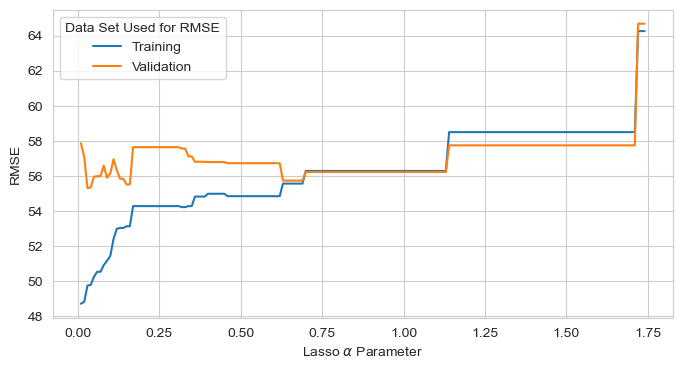

In [164]:
fig, ax = plt.subplots(figsize=(8,4))
sns.lineplot(data=df, x='Alpha', y='Training', label='Training', ax=ax)
sns.lineplot(data=df, x='Alpha', y='Validation', label='Validation', ax=ax)
ax.set_ylabel('RMSE')
ax.set_xlabel(r'Lasso $\alpha$ Parameter')
ax.legend(title='Data Set Used for RMSE')
plt.savefig('training_validation.svg')
plt.show()

In [155]:
df.iloc[df['Validation'].argmin()]

Alpha          0.030000
Training      49.734269
Validation    55.295296
Name: 2, dtype: float64

In [156]:
model3 = mdl(form(0.03))
model3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:               OLS               Adj. R-squared:      0.522    
Dependent Variable:  I(Y ** 0.5)       AIC:                 1201.8511
Date:                2023-03-02 09:58  BIC:                 1344.5849
No. Observations:    262               Log-Likelihood:      -560.93  
Df Model:            39                F-statistic:         8.311    
Df Residuals:        222               Prob (F-statistic):  3.38e-26 
R-squared:           0.594             Scale:               5.0011   
---------------------------------------------------------------------
                    Coef.   Std.Err.    t    P>|t|   [0.025   0.975] 
---------------------------------------------------------------------
Intercept           86.8049  31.2241  2.7801 0.0059  25.2714 148.3385
C(SEX)[T.Male]      -8.9935   4.4239 -2.0329 0.0433 -17.7118  -0.2752
AGE                 -0.3695   0.1673 -2.2083 0.0282  -0.6992  -0.0398
AGE:C(SEX)[T.Male]   0.0347   0.0283  1.2257 0.2216  -0.0211   0.0904
BMI                  0.0871   0.4029  0.2161 0.8291  -0.7070   0.8811
BMI:C(SEX)[T.Male]   0.1204   0.0789  1.5244 0.1288  -0.0352   0.2759
BP                   0.1260   0.1441  0.8742 0.3830  -0.1580   0.4099
BP:C(SEX)[T.Male]    0.0154   0.0247  0.6230 0.5340  -0.0333   0.0641
S1                  -0.1880   0.1671 -1.1252 0.2617  -0.5173   0.1413
S3                  -0.1212   0.2838 -0.4272 0.6696  -0.6805   0.4380
S3:C(SEX)[T.Male]    0.0074   0.0436  0.1702 0.8650  -0.0785   0.0933
S5                 -26.0874  15.0023 -1.7389 0.0834 -55.6524   3.4777
I(AGE ** 2)          0.0015   0.0009  1.6563 0.0991  -0.0003   0.0033
AGE:BMI             -0.0016   0.0032 -0.4925 0.6228  -0.0078   0.0047
AGE:BP               0.0003   0.0011  0.3035 0.7618  -0.0018   0.0024
S2                   0.2340   0.1572  1.4882 0.1381  -0.0759   0.5438
AGE:S2              -0.0004   0.0004 -0.8475 0.3977  -0.0012   0.0005
AGE:S3               0.0009   0.0013  0.7015 0.4837  -0.0016   0.0035
AGE:S5               0.0483   0.0317  1.5218 0.1295  -0.0142   0.1108
BMI:BP               0.0073   0.0029  2.5187 0.0125   0.0016   0.0129
BMI:S1              -0.0004   0.0015 -0.2488 0.8037  -0.0033   0.0026
BMI:S5              -0.1016   0.0985 -1.0317 0.3033  -0.2957   0.0925
BP:S2                0.0007   0.0005  1.5515 0.1222  -0.0002   0.0016
BP:S5               -0.0289   0.0307 -0.9403 0.3481  -0.0894   0.0316
S6                  -0.5284   0.2388 -2.2127 0.0279  -0.9990  -0.0578
S6:C(SEX)[T.Male]    0.0282   0.0349  0.8098 0.4189  -0.0405   0.0970
BP:S6               -0.0026   0.0013 -2.0476 0.0418  -0.0050  -0.0001
S4                   0.6265   1.1161  0.5613 0.5752  -1.5731   2.8261
S4:C(SEX)[T.Male]   -0.3566   0.4347 -0.8202 0.4130  -1.2133   0.5002
S1:S4               -0.0057   0.0058 -0.9819 0.3272  -0.0172   0.0058
S1:S5               -0.0090   0.0150 -0.6010 0.5485  -0.0387   0.0206
S1:S6                0.0002   0.0006  0.2556 0.7985  -0.0010   0.0014
S2:S3               -0.0008   0.0006 -1.3990 0.1632  -0.0020   0.0003
I(S3 ** 2)           0.0002   0.0010  0.1783 0.8587  -0.0017   0.0021
S3:S5                0.0389   0.0360  1.0782 0.2821  -0.0322   0.1099
S3:S6                0.0019   0.0015  1.2628 0.2080  -0.0011   0.0048
I(S4 ** 2)           0.0877   0.1356  0.6465 0.5186  -0.1796   0.3550
I(S5 ** 2)           3.3400   2.1362  1.5635 0.1194  -0.8699   7.5499
S5:S6                0.0596   0.0461  1.2932 0.1973  -0.0312   0.1505
I(S6 ** 2)           0.0020   0.0011  1.7041 0.0898  -0.0003   0.0042
---------------------------------------------------------------------
Omnibus:               0.256         Durbin-Watson:           2.034  
Prob(Omnibus):         0.880         Jarque-Bera (JB):        0.123  
Skew:                  -0.044        Prob(JB):                0.940  
Kurtosis:              3.058         Condition No.

**Model Selected**: $\sqrt{\hat{Y}} = 86.80 - 8.99(\text{SEX}=\text{MALE}) - 0.3695(\text{AGE}) + 0.0871(\text{BMI}) + 0.1260(\text{BP}) - 0.1880(\text{S1}) + 0.2340(\text{S2}) - 0.1212(\text{S3}) + 0.6265(\text{S4}) - 26.09(\text{S5}) - 0.5284(\text{S6}) + 0.0015(\text{AGE}^2) + 0.0002(\text{S3}^2) + 0.0877(\text{S4}^2) + 3.340(\text{S5}^2) + 0.0020(\text{S6}^2) + 0.0347(\text{SEX}=\text{MALE})\times(\text{AGE}) + 0.1204(\text{SEX}=\text{MALE})\times(\text{BMI})   + 0.0154(\text{SEX}=\text{MALE})\times(\text{BP}) + 0.0074(\text{SEX}=\text{MALE})\times(\text{S3})   - 0.3566(\text{SEX}=\text{MALE})\times(\text{S4}) + 0.0282(\text{SEX}=\text{MALE})\times(\text{S6}) - 0.0016(\text{AGE}\times\text{BMI}) + 0.0003(\text{AGE}\times\text{BP}) - 0.0004(\text{AGE}\times\text{S2}) + 0.0009(\text{AGE}\times\text{S3}) + 0.0483(\text{AGE}\times\text{S5}) + 0.0073(\text{BMI}\times\text{BP}) - 0.0004(\text{BMI}\times\text{S1}) - 0.1016(\text{BP}\times\text{S2}) + 0.0007(\text{BP}\times\text{S5}) - 0.0026(\text{BP}\times\text{S6}) - 0.0057(\text{S1}\times\text{S4}) - 0.0090(\text{S1}\times\text{S5}) + 0.0002(\text{S1}\times\text{S6}) - 0.0008(\text{S2}\times\text{S3}) + 0.0389(\text{S3}\times\text{S5}) + 0.0019(\text{S3}\times\text{S6}) + 0.0596(\text{S5}\times\text{S6})$

In [157]:
rmse_val3 = mean_squared_error(y_val, model3.predict(X_val)**2) ** 0.5
print(rmse_val3)

55.2952957601431


The analysis of an RMSE-optimal model only bolstered my opting for the smaller BIC-based model, which happened to be the same one. The fact that it had nearly the best RMSE while also not being overfit on the training data tells me it's a good model.

In [158]:
from sklearn.metrics import explained_variance_score
print(explained_variance_score(y_train, model1.predict(X_train)**2))
print(explained_variance_score(y_train, model2.predict(X_train)**2))
print(explained_variance_score(y_train, model3.predict(X_train)**2))

0.5419136356285528
0.5032102096526081
0.6009660846534712


In [159]:
print(explained_variance_score(y_val, model1.predict(X_val)**2))
print(explained_variance_score(y_val, model2.predict(X_val)**2))
print(explained_variance_score(y_val, model3.predict(X_val)**2))

0.49302127997884126
0.4732318261948162
0.49081649949262574


In [84]:
model = model2

# Check Assumptions

In [85]:
diag = X_train.join(y_train).copy()
diag['resid'] = model.resid
diag['pred'] = model.fittedvalues

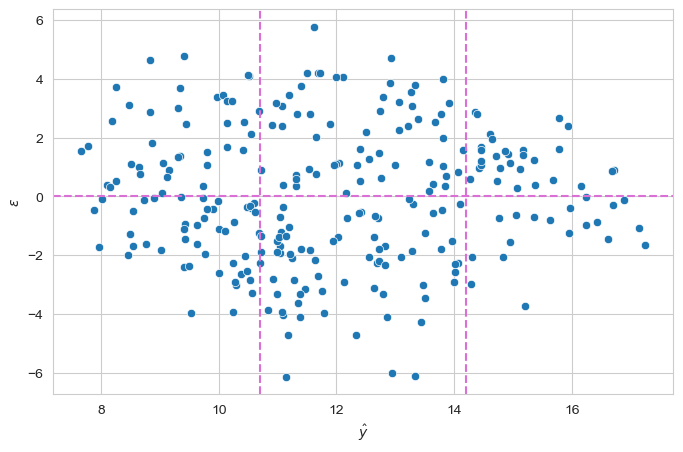

In [88]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(data=diag, x='pred', y='resid', ax=ax)
xlim = ax.get_xlim()
ax.axvline(x=xlim[0] + 1/3*(xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax.axvline(x=xlim[0] + 2/3*(xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax.axhline(y=0, color='orchid', linestyle='--')
ax.set_xlabel('$\hat{y}$')
ax.set_ylabel('$\epsilon$')
plt.savefig('residuals.svg')
plt.show()

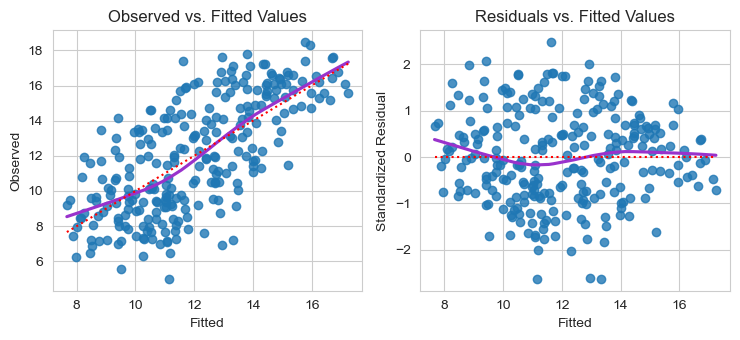

In [89]:
fig, ax = linearity_test(model,y_train**0.5)
fig.tight_layout()
plt.savefig('Assumption1.svg')
plt.show()

There may be a little heteroscedasticity here, especially in the lower left section, due to the data being right-skewed and limited to positive values.

Let's try a new function, which I'll be discussing in the Week 9 examples.


 Breusch-Pagan test ----
                                  value
Lagrange multiplier statistic  5.088569
p-value                        0.278330
f-value                        1.272581
f p-value                      0.281185

 Goldfeld-Quandt test ----
                value
F statistic  1.139764
p-value      0.231926

 Residuals plots ----


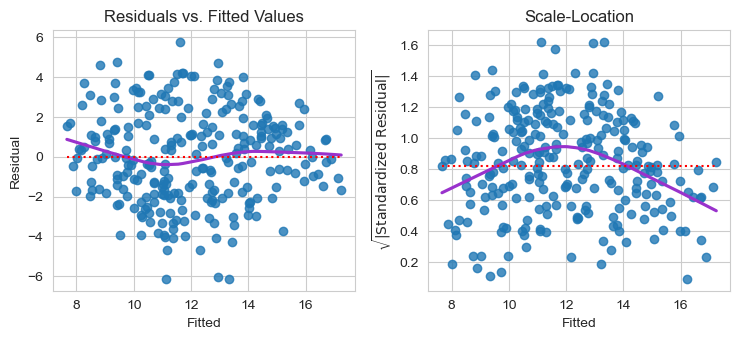

In [90]:
fig, ax = homoscedasticity_test(model)
fig.tight_layout()
plt.savefig('Assumption2.svg')
plt.show()

This confirms some remaining heteroscedasticity, but it isn't egregious. We'll press ahead.

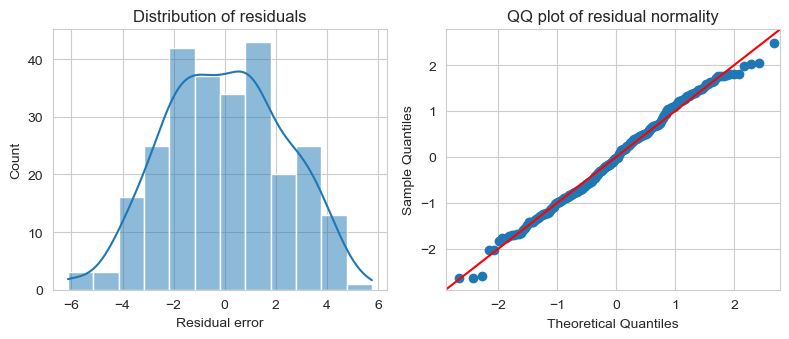

In [91]:
fig, ax = plt.subplots(1,2,figsize=(8,3.5))
sns.histplot(data=diag, x='resid', kde=True, ax=ax[0])
sm.qqplot(diag['resid'], fit=True, line='45', ax=ax[1])
ax[0].set_title('Distribution of residuals')
ax[0].set_xlabel('Residual error')
ax[1].set_title('QQ plot of residual normality')
fig.tight_layout()
plt.savefig('Assumption3.svg')
plt.show()

Shapiro-Wilk test ---- statistic: 0.9915, p-value: 0.1362
D'Agostino-Pearson Omnibus test ---- statistic: 4.6244, p-value: 0.0990
Lilliefors test ---- statistic: 0.0419, p-value: 0.3933
Jarque-Bera test ---- statistic: 2.9737, p-value: 0.22608058666859188
Kolmogorov-Smirnov test ---- statistic: 0.0433, p-value: 0.6939
Anderson-Darling test ---- statistic: 0.5517, 5% critical value: 0.7750
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


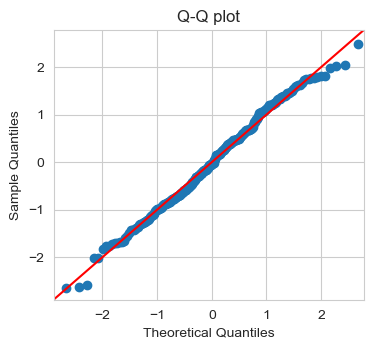

In [92]:
fig, ax = normality_of_residuals_test(model)
plt.show()

Residuals seem approximately normally distributed, though the Omnibus test is barely significant for $\alpha=0.1$. That's good. I usually would use a much smaller $\alpha=0.01$ for normality tests.

There's no reason to believe we have the data in the order collected, so we'll have to assume independence.

In [93]:
influence = model.get_influence()
diag['resid_std'] = influence.resid_studentized_internal
diag['resid_stud'] = influence.resid_studentized_external

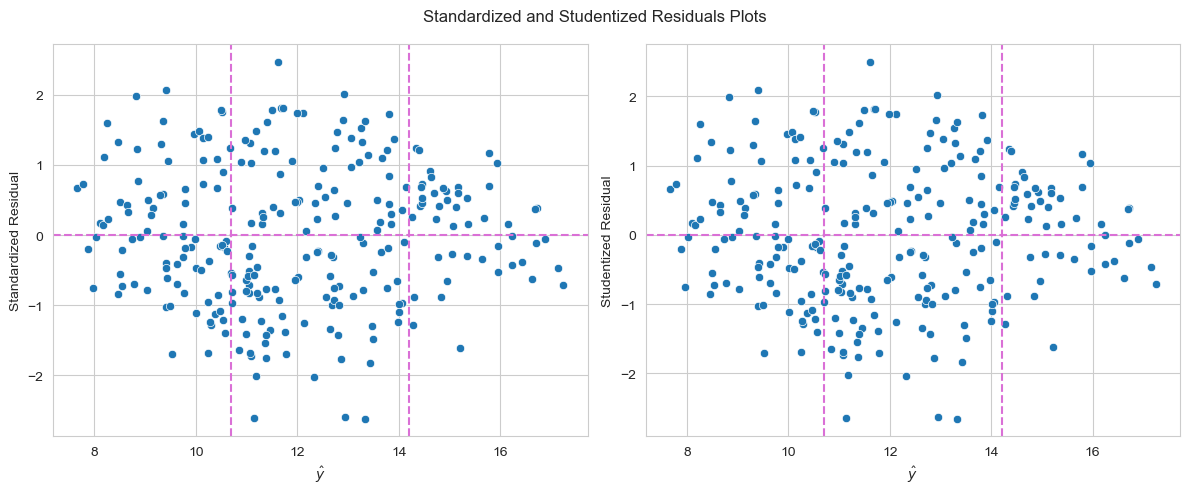

In [94]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(data=diag, x='pred', y='resid_std', ax=ax[0])
xlim = ax[0].get_xlim()
ax[0].axvline(x=xlim[0] + 1/3*(xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax[0].axvline(x=xlim[0] + 2/3*(xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax[0].axhline(y=0, color='orchid', linestyle='--')
ax[0].set_xlabel('$\hat{y}$')
ax[0].set_ylabel('Standardized Residual')
sns.scatterplot(data=diag, x='pred', y='resid_stud', ax=ax[1])
xlim = ax[1].get_xlim()
ax[1].axvline(x=xlim[0] + 1/3*(xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax[1].axvline(x=xlim[0] + 2/3*(xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax[1].axhline(y=0, color='orchid', linestyle='--')
ax[1].set_xlabel('$\hat{y}$')
ax[1].set_ylabel('Studentized Residual')
fig.suptitle('Standardized and Studentized Residuals Plots')
fig.tight_layout()
plt.savefig('outlierplots.svg')
plt.show()

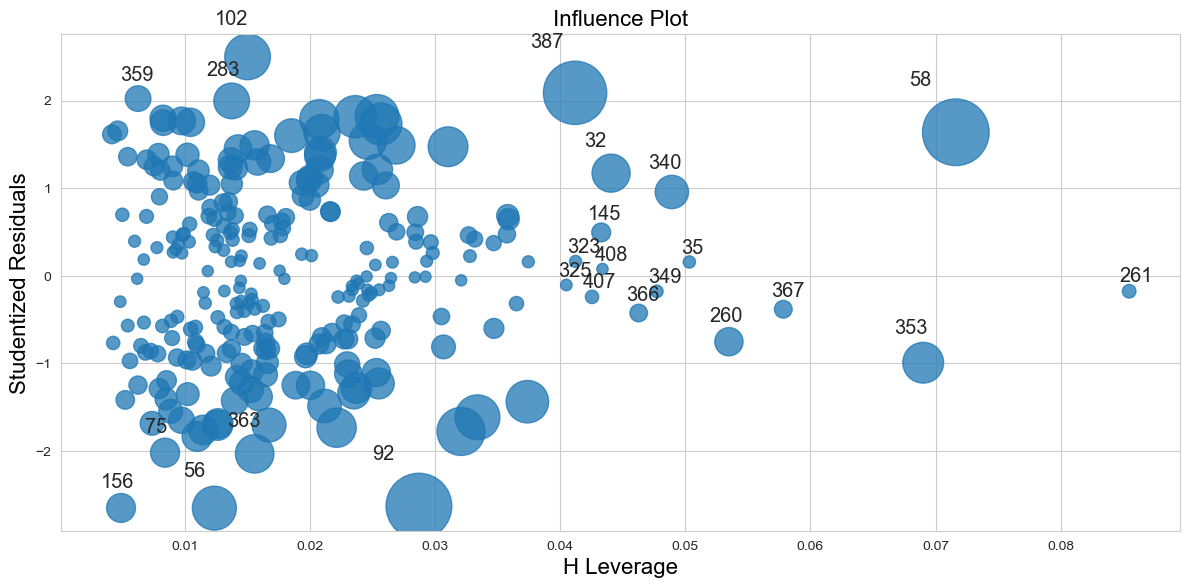

In [95]:
fig, ax = plt.subplots(figsize=(12,6))
smg.influence_plot(model, ax=ax)
#ax.set_ylim(-3.5,3.5)
plt.tight_layout()
plt.savefig('influenceplot.svg')
plt.show()

Standardized and Studentized residuals show no major outliers or influence points. Influence plot highlights points 387 and 58 as a potential leverage points of concern. Let's highlight those in the residuals just to look at where it is.

In [104]:
diag.loc[[387,58]]

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y,resid,pred,resid_std,resid_stud
387,36,Female,27.8,73.0,153,104.4,42.0,4.0,3.4965,73,201.0,4.769447,9.408000,2.074466,2.087981
58,60,Female,20.4,105.0,198,78.4,99.0,2.0,4.6347,79,170.0,3.692570,9.345835,1.632192,1.637523


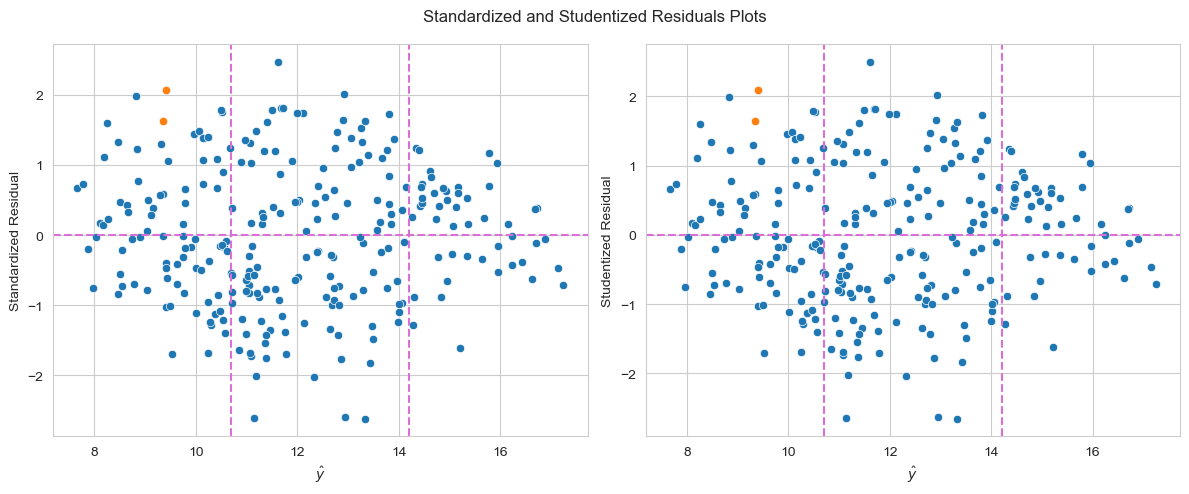

In [105]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(data=diag, x='pred', y='resid_std', ax=ax[0])
sns.scatterplot(data=diag.loc[[387,58]], x='pred', y='resid_std', ax=ax[0])
xlim = ax[0].get_xlim()
ax[0].axvline(x=xlim[0] + 1/3*(xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax[0].axvline(x=xlim[0] + 2/3*(xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax[0].axhline(y=0, color='orchid', linestyle='--')
ax[0].set_xlabel('$\hat{y}$')
ax[0].set_ylabel('Standardized Residual')
sns.scatterplot(data=diag, x='pred', y='resid_stud', ax=ax[1])
sns.scatterplot(data=diag.loc[[387,58]], x='pred', y='resid_stud', ax=ax[1])
xlim = ax[1].get_xlim()
ax[1].axvline(x=xlim[0] + 1/3*(xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax[1].axvline(x=xlim[0] + 2/3*(xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax[1].axhline(y=0, color='orchid', linestyle='--')
ax[1].set_xlabel('$\hat{y}$')
ax[1].set_ylabel('Studentized Residual')
fig.suptitle('Standardized and Studentized Residuals Plots')
fig.tight_layout()
plt.show()

It's easy to see how this is creating leverage, but there's no reason to believe these are invalid points.

# VIF

In [106]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
yVIF, XVIF = dmatrices(form(0.69), diab_train, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(XVIF.values, ii) \
              for ii in range(XVIF.shape[1])]
vif['features'] = XVIF.columns
print(vif)

          VIF   features
0  168.877336  Intercept
1    1.409635        BMI
2    1.299859         BP
3    1.251919         S3
4    1.420921         S5


These VIFs are good except in the intercept. We can use the standardized data instead (which would result in the same model but is centered) and that gets rid of the intercept issue. That would also help if we had interactions or squared terms.

In [107]:
yVIF, XVIF = dmatrices(form(0.69), X_poly.join(y_train), return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(XVIF.values, ii) \
              for ii in range(XVIF.shape[1])]
vif['features'] = XVIF.columns
print(vif)

        VIF   features
0  1.000000  Intercept
1  1.409635        BMI
2  1.299859         BP
3  1.251919         S3
4  1.420921         S5


Using standardized inputs, we see no VIF issues.

# Model Visualization

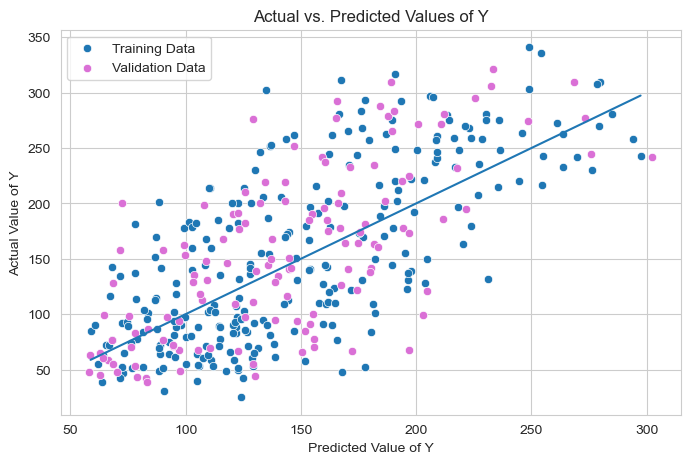

In [108]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x=model.fittedvalues**2, y=y_train, ax=ax, label='Training Data')
sns.scatterplot(x=model.predict(X_val)**2, y=y_val, ax=ax, 
                label='Validation Data', color='orchid')
sns.lineplot(x=model.fittedvalues**2, y=model.fittedvalues**2, ax=ax)
ax.set_xlabel('Predicted Value of Y')
ax.set_ylabel('Actual Value of Y')
ax.set_title('Actual vs. Predicted Values of Y')
plt.savefig('act_pred.svg')
plt.show()

# Predictions and Prediction Intervals

In [137]:
pred = model.get_prediction(diabetes_test)

In [138]:
diabetes_test[['Lower','Upper']] = pred.conf_int(obs=True, alpha=0.1) ** 2

In [139]:
diabetes_test['Y'] = pred.predicted_mean ** 2

# Applying to Withheld Data

I promise I actually did this after selecting my final model. I was kind of surprised that I selected the best-performing of the three models.

In [140]:
withheld = pd.read_csv('diabetes_instructor.csv', index_col=0)

In [141]:
X_test = withheld.drop('Y', axis=1)
y_test = withheld['Y']

In [142]:
# Model 1 - Overfit
mean_squared_error(y_test, model1.predict(diabetes_test)**2) ** 0.5

52.06644728808349

In [143]:
# Model 2 - Nice!
mean_squared_error(y_test, model2.predict(diabetes_test)**2) ** 0.5

49.88542364133066

In [184]:
# Model 3 - Obviously the same model as Model 2
mean_squared_error(y_test, model3.predict(diabetes_test)**2) ** 0.5

52.728970605140425

In [148]:
# Average CI width
(diabetes_test['Upper'] - diabetes_test['Lower']).mean()

179.27610560934704

This probably isn't a practically useful model. This width is (as I understand it) a huge range of diabetes diagnostic values.

In [145]:
# Coverage?
errors = (y_test < diabetes_test['Lower']) | (y_test > diabetes_test['Upper'])

In [146]:
errors.sum() / len(errors)

0.02

Well, I only missed one point where I would have expected to miss five. This model is slightly under-confident.

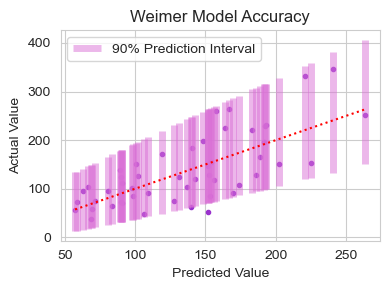

In [149]:
x = diabetes_test['Y']
lower = diabetes_test['Lower']
upper = diabetes_test['Upper']
fig, ax = plt.subplots(figsize=(4,3))
ax.scatter(x=x, y=y_test, color='darkorchid', marker='.')
ax.vlines(x=x, ymin=lower, ymax=upper, color='orchid', alpha=0.5, linewidth=5, label='90% Prediction Interval')
ax.plot([x.min(), x.max()], [x.min(), x.max()], color='red', ls=':')
ax.legend(loc='upper left')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual Value')
ax.set_title(f'Weimer Model Accuracy')
fig.tight_layout()
plt.savefig('WeimerAccuracy.svg')
plt.show()

In [154]:
len(X_val)

130